In [120]:
library(tidyverse)
library(tidymodels)
library(readxl)

raisin_data <- read_csv("https://github.com/dylankim990/DSCI100_Group_1/raw/main/data/Raisin_Dataset.csv") %>% mutate(Class = as_factor(Class))

Parsed with column specification:
cols(
  Area = col_double(),
  MajorAxisLength = col_double(),
  MinorAxisLength = col_double(),
  Eccentricity = col_double(),
  ConvexArea = col_double(),
  Extent = col_double(),
  Perimeter = col_double(),
  Class = col_character()
)



In [122]:
#1. choose columns; forward selection 
#2. choose K; cross-validation
#3. predict and find accuracy on testing set; train and predict 
#4. compare the model prediction with other research model predictions

#### 1. choose columns; forward selection 

Before finding K through cross-validation, we will be using forward selection to find the best combination of predictors that shows highest accuracy rates. For efficiency, we eliminated the combinations with too many predictors. Since selecting predictors is a part of tuning my classifier, we have only used training dataset for the process. Below is the codes. There are two forloops. First one increases the predictor set sizes and the second one selects which predictor to add, by checking which one gives the best accuracy rate. For each combination of predictors, the loop created a recipe, with scaling, and inserted into a workflow to tune the K-NN classifier using 5-fold cross-validation. Then, we have visualized the Number of Predictors against Estimated Accuracy to find the highest accuracy rate, the combination of the three predictors: Perimeter, Eccentricity, and Area had the highest accuracy. 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Perimeter,0.8562774
2,Class ~ Perimeter+Eccentricity,0.8651010
3,Class ~ Perimeter+Eccentricity+Area,0.8696444
4,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength,0.8681299
5,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea,0.8637182
6,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea+Extent,0.8651229
7,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea+Extent+MinorAxisLength,0.8680641


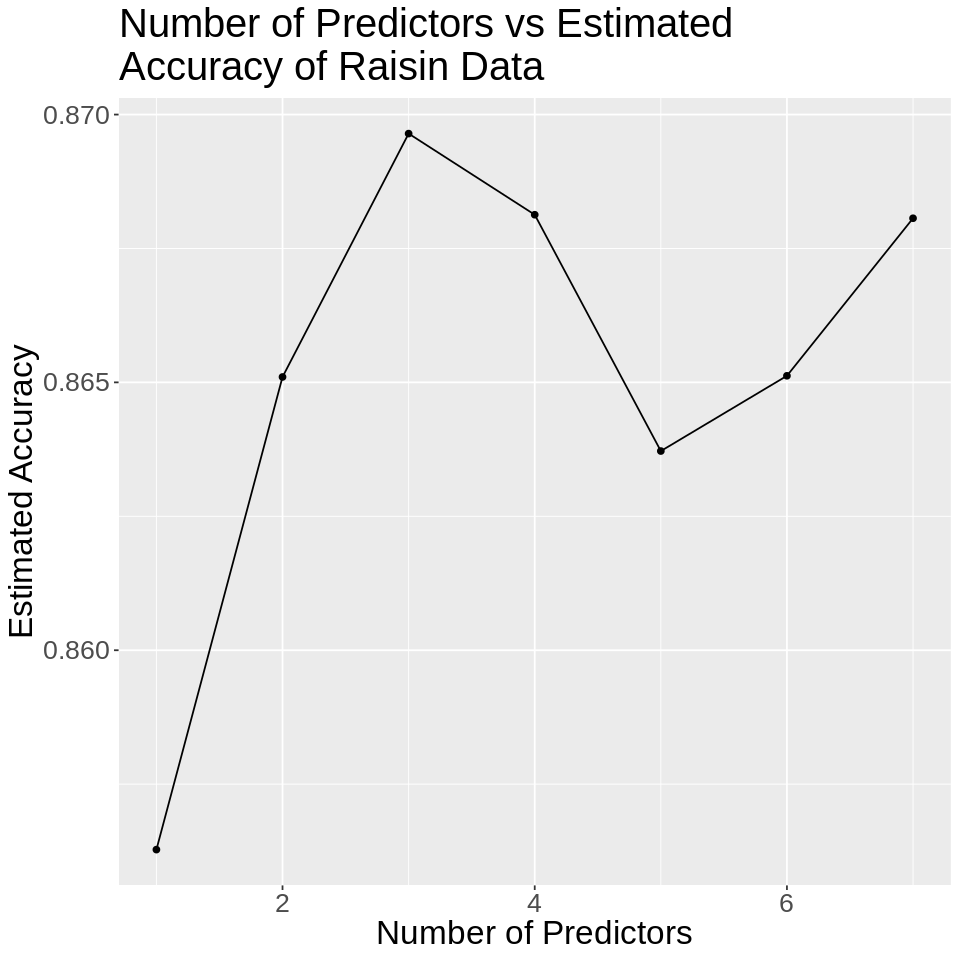

In [121]:
set.seed(5805)
raisin_split <- initial_split(raisin_data, prop = 0.75 ,strata = Class)
raisin_training <- training(raisin_split)
raisin_testing <- testing(raisin_split)

raisin_subset <- raisin_training %>%
  select(Area,
         MajorAxisLength, 
         MinorAxisLength, 
         Eccentricity, 
         ConvexArea, 
         Extent, 
         Perimeter, 
         Class)

names <- colnames(select(raisin_subset, -Class))
# creating an empty tibble which will store the accuracy results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
# create a model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")
# 5-fold cross-validation
raisin_vfold <- vfold_cv(raisin_subset, v = 5, strata = Class)

# total # of predictors
n_total <- length(names)

# creating to store selected predictors
selected <- c()
#loops to try all the models
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()

#inner loop for model string for different combinations of predictors
    for (j in 1:length(names)) {
        # create a model string for the combinations of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
# created a recipe from the model string
        raisin_recipe <- recipe(as.formula(model_string), 
                                data = raisin_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
# tune the KNN classifier with these predictors, 
# and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(raisin_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = raisin_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

# adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
        accuracies <- accuracies %>% 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies
options(repr.plot.width = 8, repr.plot.height = 8)

accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Predictors", y = "Estimated Accuracy", title = "Number of Predictors vs Estimated 
Accuracy of Raisin Data") +
    theme(text = element_text(size = 20))

accuracies_plot

#### 2. choose K; cross-validation

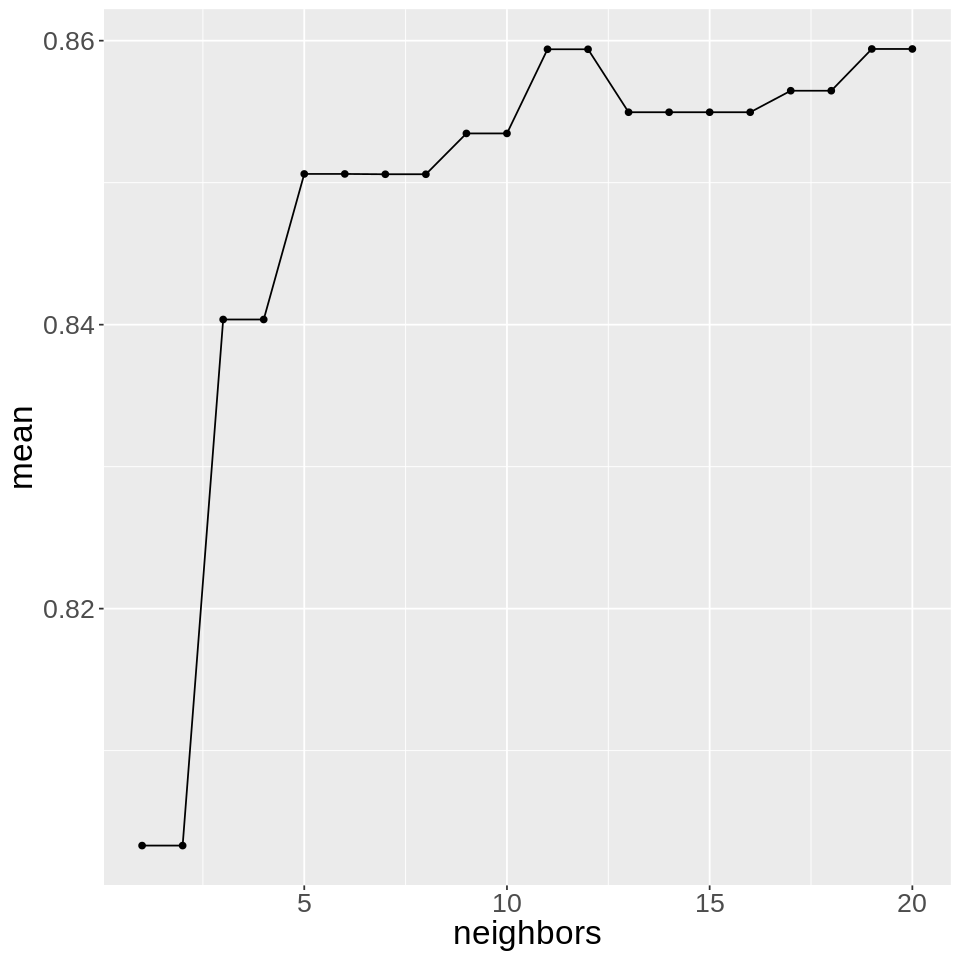

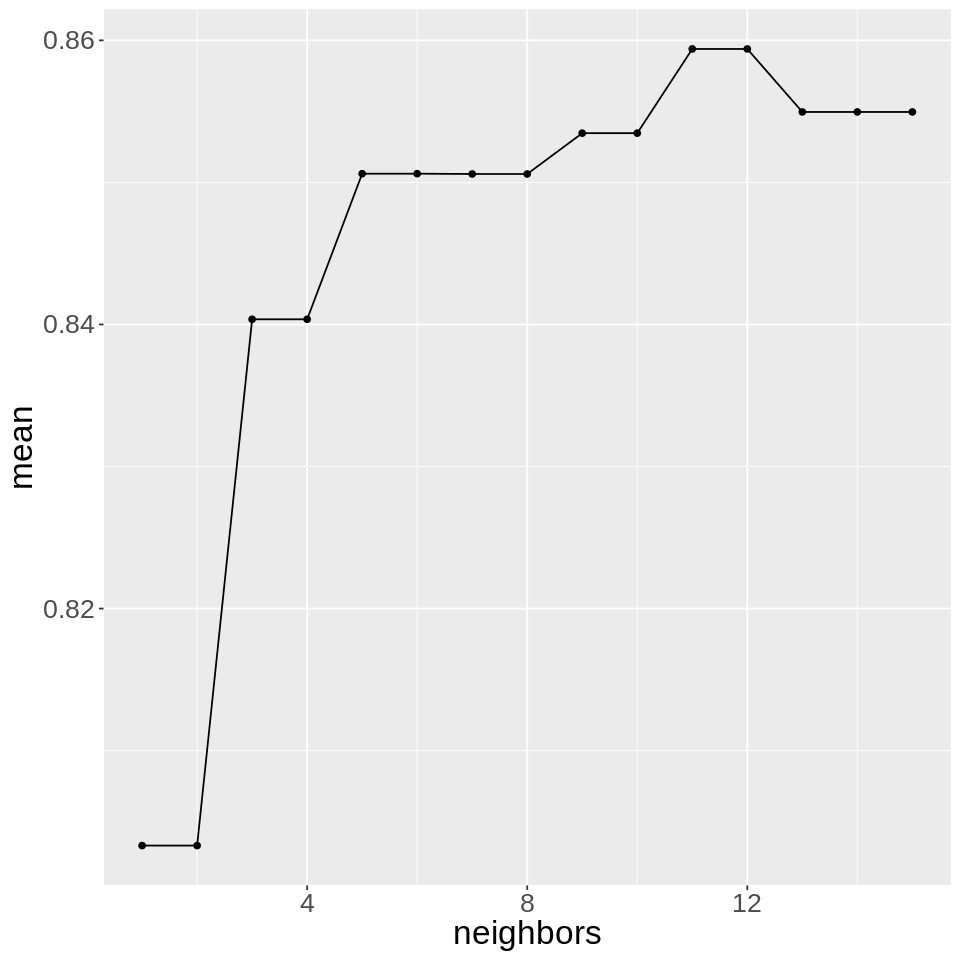

In [113]:
set.seed(5805)
raisin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_recipe <- recipe(Class ~ Perimeter + Eccentricity + Area, data = raisin_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
#do I need scale? yes I need. Should I mention y I need the scale?

onetotwenty <- tibble(neighbors = seq(1,20))
raisin_vfold <- vfold_cv(raisin_training, v = 5, strata = Class)
#should I justify y I am using 5 of v?

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = onetotwenty) %>%
#should I justify y I am using 10 ks?
    collect_metrics() %>%
    filter(.metric == "accuracy")

ggplot(raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

filtered_raisin_workflow <- filter(raisin_workflow, neighbors <= 15)
ggplot(filtered_raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))


#### 3. predict and find accuracy on testing set; train and predict  

In [119]:
set.seed(5805)
raisin_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_best_spec) %>%
    fit(data = raisin_training) 

raisin_result <- raisin_workflow %>%
    predict(raisin_testing) %>%
    bind_cols(raisin_testing) 

raisin_accuracy <- raisin_result %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
raisin_accuracy

raisin_conf_mat <- raisin_result %>%
    conf_mat(truth = Class, estimate = .pred_class)
raisin_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8303571


          Truth
Prediction Kecimen Besni
   Kecimen      99    25
   Besni        13    87

finding: accuracy is 0.8303571

#### 4. compare the model prediction with other research model predictions

In [161]:
#data from raisin_conf_mat
tp <- 99
fp <- 25
fn <- 13
tn <- 87

#formula to find accuracy, sensitivity, etc
accuracy <- ((tp + tn)/(tp + fp + tn + fn))*100
sensitivity <- (tp / (tp + fn))*100

#decided to use summary(raisin_conf_mat)

# KNN <- as.data.frame(t(summary(raisin_conf_mat))) %>%
#     rename(Accuracy = V1)

KNN <- summary(raisin_conf_mat) %>%
    filter(.metric == "accuracy" | .metric == "sens" | .metric == "spec" | .metric == "precision")

KNN 
#filter the .metrics that also appeared on the research's performance measurements: accuracy, sens, spec, precision


#the missing metrics compared to the research is filled in by the provided formula
#missing: F1-Score, Negative_Predictive_Value, False_Positive_Rate, False_Discovery_Rate, False_Negative_Rate


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8303571
sens,binary,0.8839286
spec,binary,0.7767857
precision,binary,0.7983871


In [158]:
measure_labels <- c("Accuracy", "Sensivity", "Specificity", "Precision", "F1-Score",
                    "Negative_Predictive_Value", "False_Positive_Rate", "False_Discovery_Rate",
                    "False_Negative_Rate")

measure_lr <- c(85.22, 84.09, 86.44, 86.89, 85.46, 83.56, 13.56, 13.11, 15.91)
measure_mlp <- c(86.33, 84.57, 88.29, 88.89, 86.67, 83.78, 11.71, 11.11, 15.41)
measure_svm <- c(86.44, 84.17, 89.05, 89.78, 86.88, 83.11, 10.95, 10.22, 15.83)

measurements <- tibble(performance_measure = measure_labels, LR = measure_lr, MLP = measure_mlp, SVM = measure_svm)
measurements

# measurements_t <- as.data.frame(t(measurements))
# measurements_t

performance_measure,LR,MLP,SVM
<chr>,<dbl>,<dbl>,<dbl>
Accuracy,85.22,86.33,86.44
Sensivity,84.09,84.57,84.17
Specificity,86.44,88.29,89.05
Precision,86.89,88.89,89.78
F1-Score,85.46,86.67,86.88
Negative_Predictive_Value,83.56,83.78,83.11
False_Positive_Rate,13.56,11.71,10.95
False_Discovery_Rate,13.11,11.11,10.22
False_Negative_Rate,15.91,15.41,15.83


,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
performance_measure,Accuracy,Sensivity,Specificity,Precision,F1-Score,Negative_Predictive_Value,False_Positive_Rate,False_Discovery_Rate,False_Negative_Rate
LR,85.22,84.09,86.44,86.89,85.46,83.56,13.56,13.11,15.91
MLP,86.33,84.57,88.29,88.89,86.67,83.78,11.71,11.11,15.41
SVM,86.44,84.17,89.05,89.78,86.88,83.11,10.95,10.22,15.83
